<center><h1>DeepGlobe Road Extraction</h1></center>

* Final Submission

## 1. `import` Packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2 as cv
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    BatchNormalization,
    Dropout,
    Activation,
    Concatenate
)
from tensorflow.keras.models import Model

## 2. Load Model

In [ ]:
project_path = '/content/drive/MyDrive/AAIC/SCS-2/deep_globe_road_extraction/'

In [ ]:
unet_scratch_name = 'unet_scratch'
unet_scratch_aug_name = 'unet_scratch_augmentated'

In [ ]:
## Reference → https://youtu.be/GAYJ81M58y8
## The below code is taken from the above video link. Although I have modified it.
## I give full credit to the author of the video and the creators of UNet.

class UNET:
    # convolution block
    def _convolve(self, input_, filters):
        x = Conv2D(filters=filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        x = Conv2D(filters=filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        return x
    
    # up-sampling and convolotion block
    def _convolve_by_upsampling(self, input_, skip_connector, filters, rate):
        x = Conv2DTranspose(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(input_)
        x = concatenate([x, skip_connector])
        x = Dropout(rate)(x)
        x = self._convolve(input_=x, filters=filters)
        return x
    
    # UNET main model 
    def unet_main(self, input_, filters=16, rate=0.05):
        # left encoder Path
        c1 = self._convolve(input_=input_, filters=filters)
        p1 = MaxPooling2D(pool_size=(2, 2))(c1)
        p1 = Dropout(rate)(p1)
        
        c2 = self._convolve(input_=p1, filters=filters * 2)
        p2 = MaxPooling2D(pool_size=(2, 2))(c2)
        p2 = Dropout(rate)(p2)
        
        c3 = self._convolve(input_=p2, filters=filters * 4)
        p3 = MaxPooling2D(pool_size=(2, 2))(c3)
        p3 = Dropout(rate)(p3)
        
        c4 = self._convolve(input_=p3, filters=filters * 8)
        p4 = MaxPooling2D(pool_size=(2, 2))(c4)
        p4 = Dropout(rate)(p4)

        # middle bridge
        c5 = self._convolve(input_=p4, filters=filters * 16)
        
        # right decoder path
        c6 = self._convolve_by_upsampling(input_=c5, skip_connector=c4, filters=filters * 8, rate=rate)
        c7 = self._convolve_by_upsampling(input_=c6, skip_connector=c3, filters=filters * 4, rate=rate)
        c8 = self._convolve_by_upsampling(input_=c7, skip_connector=c2, filters=filters * 2, rate=rate)
        c9 = self._convolve_by_upsampling(input_=c8, skip_connector=c1, filters=filters * 1, rate=rate)
        
        output_ = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(c9)
        
        model = Model(inputs=[input_], outputs=[output_])
        
        return model

In [ ]:
def get_unet_model(model_name):
    u = UNET()
    
    inputs = Input(shape=(256, 256, 3))
    model = u.unet_main(input_=inputs)
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    model_path = project_path + 'models/{}.h5'.format(model_name)
    if not os.path.isfile(path=model_path):
        print('Please train the model first.')
    else:
        model.load_weights(model_path)
    
    return model

## 3. Load Image

In [ ]:
def load_image(image_name, show_plot=False):
    image_path = project_path + 'test_images/' + image_name
    simage = plt.imread(image_path)

    if show_plot:
        plt.figure(figsize=(6, 6))
        plt.title(image_name)
        plt.imshow(simage)
        plt.axis("off")
        plt.show()
        return None
    
    return simage

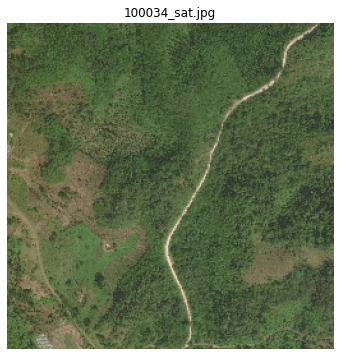

In [ ]:
load_image(image_name='100034_sat.jpg', show_plot=True)

## 4. Extract Road Path

In [ ]:
def extract_road_path(model_name, image_name, show_plot=False, save_fig=False):
    simage = load_image(image_name=image_name)
    model = get_unet_model(model_name=model_name)

    # prediction
    predicted_image  = model.predict(simage[np.newaxis,:,:,:])
    predicted_mask = predicted_image.reshape(simage.shape[0], simage.shape[1])

    # automatic threshold identification
    pmask_thresh = threshold_otsu(predicted_mask)
    # binarizing the mask
    th, predicted_mask = cv.threshold(src=predicted_mask, thresh=pmask_thresh, maxval=255, type=cv.THRESH_BINARY)

    rs, gs, bs = cv.split(simage)
    rsp = rs + predicted_mask
    rsp = np.where((rsp > 255), 255, rsp)

    gsp = gs + predicted_mask
    gsp = np.where((gsp > 255), 0, gsp)

    bsp = bs + predicted_mask
    bsp = np.where((bsp > 255), 0, bsp)

    simage_er = np.dstack((rsp, gsp, bsp))
    simage_er = simage_er.astype('uint8')
    
    if save_fig:
        simage_er_sav = np.dstack((bsp, gsp, rsp))
        simage_er_sav = simage_er_sav.astype('uint8')

        if 'augmentated' in model_name: file_name = 'pred_aug_{}'.format(image_name)
        else: file_name = 'pred_noaug_{}'.format(image_name)
        
        cv.imwrite(file_name, simage_er_sav)
    
    if show_plot:
        plt.figure(figsize=(10, 6))

        plt.subplot(121)
        plt.title('Original - {}'.format(image_name))
        plt.imshow(simage)
        plt.axis("off")

        plt.subplot(122)
        plt.title('Prediction - {}'.format(image_name))
        plt.imshow(simage_er)
        plt.axis("off")

        plt.show()
        return None
    
    return simage_er

### 4.1. U-NET Model

#### 4.1.1. No Augmentation

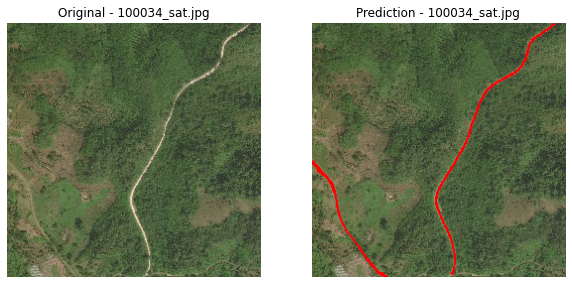

In [ ]:
extract_road_path(model_name=unet_scratch_name, image_name='100034_sat.jpg', show_plot=True)

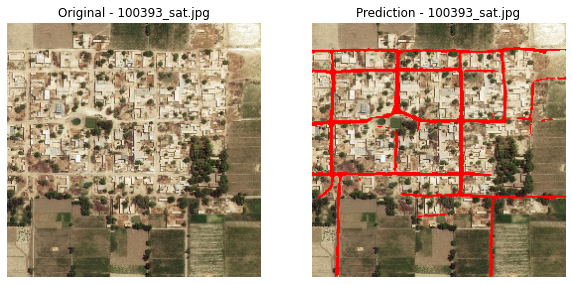

In [ ]:
extract_road_path(model_name=unet_scratch_name, image_name='100393_sat.jpg', show_plot=True)

#### 4.1.2. Augmentation

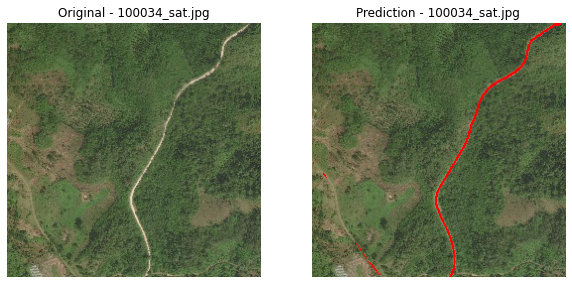

In [ ]:
extract_road_path(model_name=unet_scratch_aug_name, image_name='100034_sat.jpg', show_plot=True)

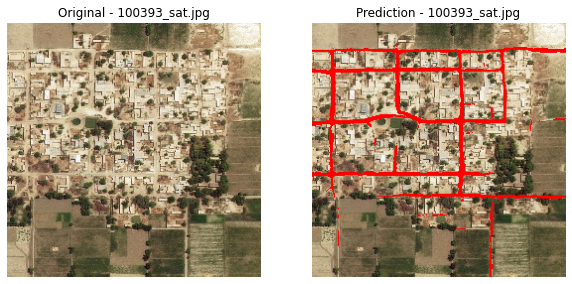

In [ ]:
extract_road_path(model_name=unet_scratch_aug_name, image_name='100393_sat.jpg', show_plot=True)

## 5. UI Part

* The video link - https://youtu.be/488uCkulDxA

<center><img src="https://user-images.githubusercontent.com/63333753/154812402-c213ee20-f871-41d4-b835-337fd4c5a6cb.png"></center>

**End**